# Project Objective

The growth of oil palm plantations has become a significant agricultural trend, exerting considerable economic and environmental influence. Despite its presence in numerous everyday products like shampoo, donuts, and ice cream, many remain unaware of its direct association. However, this crop, confined to tropical regions, has driven deforestation, heightened carbon emissions, and contributed to biodiversity decline, albeit creating numerous employment opportunities.

Given the substantial impact on millions of livelihoods and tropical ecosystems, how can we effectively pursue cost-effective, timely, and scalable approaches to manage and regulate the expansion of oil palm cultivation worldwide?

**<font color='skyblue'>This project aims to develop a model capable of analyzing satellite images depicting oil palm plantations, predicting the likelihood of these images containing such plantations.</font>**

- The dataset below is from WiDS Datathon 2019 Kaggle competition. 
- Link: https://www.kaggle.com/competitions/widsdatathon2019/data
- As the original competition file lacks a test file, the test data is generated by partitioning the provided train data for this project.

## Data Dictionary

|Features|Description|
|--------|------------|
|`image_id`|Image Id of the oil palm plantation images.|
|`has_oilpalm`|The binary values denoting the presence of oil palm (1) or its absence (0) in the image.|
|`score`|A confidence score indicating whether the image contains an oil palm or not.|

# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from PIL import Image

import random
import pickle

random.seed(0) # fix the randomness

# Data Acquisition

In [2]:
training_label = pd.read_csv(r"C:\Users\nene0\Downloads\widsdatathon2019\traininglabels.csv")
training_label.head(10)

image_id  has_oilpalm   score
0  img_000002017.jpg            0  0.7895
1  img_000012017.jpg            0  1.0000
2  img_000022017.jpg            0  1.0000
3  img_000072017.jpg            0  1.0000
4  img_000082017.jpg            0  1.0000
5  img_000092017.jpg            0  1.0000
6  img_000102017.jpg            0  1.0000
7  img_000112017.jpg            0  0.8352
8  img_000132017.jpg            0  1.0000
9  img_000142017.jpg            0  1.0000

# Data Analysis

In [3]:
def sorted_images(df):
    """This function facilitates the selection of image_ids specifically from the year 2017 and subsequently removes the '2017' identifier from these image_ids."""
    new_df = df[df['image_id'].str.endswith("17.jpg")]
    copied_df = new_df.copy()
    copied_df['image_id'] = copied_df['image_id'].str.replace("2017.jpg", "")
    return copied_df

In [4]:
training_label = sorted_images(training_label)
training_label

image_id  has_oilpalm   score
0     img_00000            0  0.7895
1     img_00001            0  1.0000
2     img_00002            0  1.0000
3     img_00007            0  1.0000
4     img_00008            0  1.0000
...         ...          ...     ...
7533  img_10993            0  1.0000
7534  img_10994            1  0.5989
7535  img_10995            0  1.0000
7536  img_10996            0  1.0000
7537  img_10997            0  1.0000

[7538 rows x 3 columns]

In [5]:
def save_train_test_labels(df):
    """This function enables the segregation of the initial 500 images as a test dataset, while the remaining images are saved as a train dataset."""
    test_label = df.iloc[:500]
    test_label.to_csv("test_label.csv", index=False)
    train_label = df.iloc[500:]
    train_label.to_csv("train_label.csv", index=False)

In [6]:
save_train_test_labels(training_label)

In [7]:
# read the new train label csv file:
train_label = pd.read_csv(r"C:\Users\nene0\OneDrive\바탕 화면\Python Learning\DataScienceMod2_LFZ\OilPalm_Kaggle\train_label.csv")
train_label

image_id  has_oilpalm   score
0     img_00741            0  1.0000
1     img_00742            0  1.0000
2     img_00743            0  1.0000
3     img_00744            0  1.0000
4     img_00746            0  1.0000
...         ...          ...     ...
7033  img_10993            0  1.0000
7034  img_10994            1  0.5989
7035  img_10995            0  1.0000
7036  img_10996            0  1.0000
7037  img_10997            0  1.0000

[7038 rows x 3 columns]

Our approach involves exclusive utilization of the original training labels derived from the 2017 dataset of photos. Within this specific collection of 2017 oil palm images, we plan to partition them into distinct train and test sets. The initial 500 images will be allocated to the test set, while the remaining images will compose the train set. Additionally, leveraging the sorted_images function, we'll update the 'image_id' field by eliminating the '2017' identifier.

In [8]:
train_label.describe()

has_oilpalm        score
count  7038.000000  7038.000000
mean      0.063797     0.959881
std       0.244407     0.105634
min       0.000000     0.388700
25%       0.000000     1.000000
50%       0.000000     1.000000
75%       0.000000     1.000000
max       1.000000     1.000000

In [9]:
train_label.info() # There are no missing values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7038 entries, 0 to 7037
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     7038 non-null   object 
 1   has_oilpalm  7038 non-null   int64  
 2   score        7038 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.1+ KB


The pandas describe method reveals that some images exhibit a confidence score as low as 0.38. This necessitates thorough exploration to ensure the suitability of these data for training the model. Considering the low confidence scores, it's likely that these images may not be suitable for effective model training. Hence, we intend to assess and likely remove these images from the dataset as their low confidence suggests they might not be conducive for training the model.

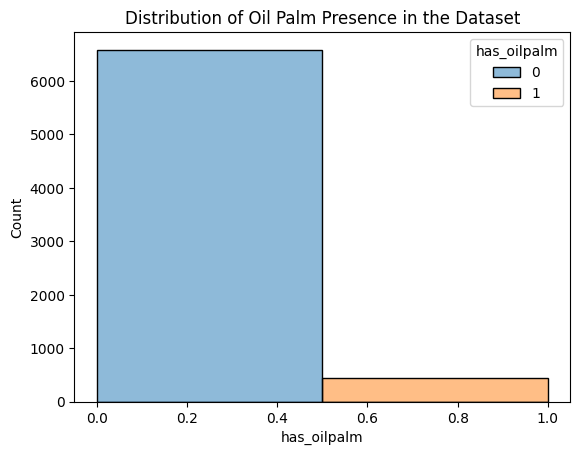

In [10]:
sns.histplot(x=train_label['has_oilpalm'], bins=2, hue=train_label['has_oilpalm'])
plt.title("Distribution of Oil Palm Presence in the Dataset")
plt.show()

In [11]:
train_label['has_oilpalm'].value_counts(normalize=True)

has_oilpalm
0    0.936203
1    0.063797
Name: proportion, dtype: float64

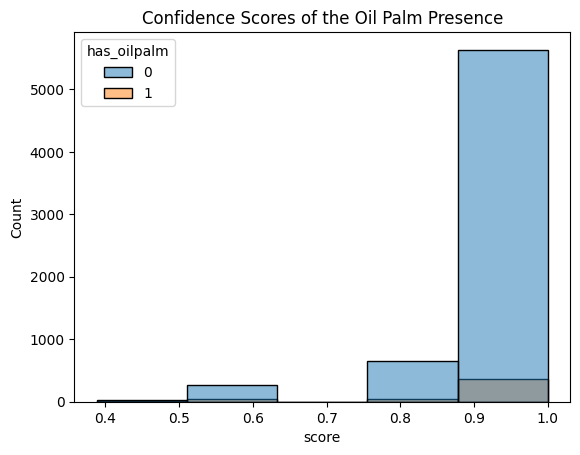

In [12]:
sns.histplot(x=train_label['score'], bins=5, hue=train_label['has_oilpalm'])
plt.title("Confidence Scores of the Oil Palm Presence")
plt.show()

The histograms reveal an imbalance within the dataset, with a mere 6% representation of images featuring oil palm plantations. Balancing this dataset is a priority for our subsequent steps. Moreover, the second histogram highlights instances where images exhibit a low confidence score in discerning oil palm presence. To ensure model efficacy, we intend to exclude these images from the training dataset.

In [13]:
def dataframes_by_score(df):
    """This function facilitates the partitioning of the training label dataframe based on the confidence scores.
    The resulting dataframes are as follows:
    - the first dataframe comprises images with scores below 1
    - the second dataframe includes images with scores above 0.8, specifically containing oil palm
    - the third dataframe consists of oil palm images with a confidence score of 1
    - the last dataframe comprises images devoid of oil palm with a confidence score of 1."""
    score_und_1 = df[df["score"] < 1]
    score_abv_80 = score_und_1[(score_und_1['has_oilpalm']==1)&(score_und_1['score']>=0.8)]
    has_oilpalm = df[(df["score"] == 1)&(df["has_oilpalm"] == 1)]
    no_oilpalm = df[(df['score']==1)&(df['has_oilpalm']==0)]
    return score_und_1, score_abv_80, has_oilpalm, no_oilpalm


In [14]:
def num_values(df, df_2, df_3, df_4):
    """This function provides the count of rows within the dataframes."""
    print(f"There are {df.shape[0]} images in first dataframe.")
    print(f"There are {df_2.shape[0]} images in second dataframe.")
    print(f"There are {df_3.shape[0]} images in third dataframe.")
    print(f"There are {df_4.shape[0]} images in fourth dataframe.")

In [15]:
low_score, score_80, has_oilpalm, no_oilpalm = dataframes_by_score(train_label)

In [16]:
low_score.head()

image_id  has_oilpalm   score
14  img_00770            0  0.7968
20  img_00783            0  0.5852
23  img_00788            0  0.4481
30  img_00796            0  0.8275
33  img_00802            0  0.8431

In [17]:
low_score['has_oilpalm'].value_counts()

has_oilpalm
0    954
1     89
Name: count, dtype: int64

In [18]:
score_80.head()

image_id  has_oilpalm   score
48    img_00822            1  0.8005
657   img_01686            1  0.8319
1741  img_03240            1  0.8019
2225  img_03917            1  0.8132
2645  img_04511            1  0.8202

In [19]:
has_oilpalm.head()

image_id  has_oilpalm  score
39   img_00813            1    1.0
58   img_00833            1    1.0
69   img_00847            1    1.0
97   img_00880            1    1.0
203  img_01021            1    1.0

In [20]:
no_oilpalm.head()

image_id  has_oilpalm  score
0  img_00741            0    1.0
1  img_00742            0    1.0
2  img_00743            0    1.0
3  img_00744            0    1.0
4  img_00746            0    1.0

In [21]:
num_values(low_score, score_80, has_oilpalm, no_oilpalm)

There are 1043 images in first dataframe.
There are 22 images in second dataframe.
There are 360 images in third dataframe.
There are 5635 images in fourth dataframe.


Through the use of the dataframes_by_score function, we partitioned the dataframes into four distinct sets. Post-separation analysis reveals a total of 1,043 images with a confidence score lower than 1, among which 22 images score above 0.8 but below 1. Given the reasonably high confidence score of 0.8, we'll incorporate these images into our training set. Now, our next step involves further visualization of the dataset.

# Data Visualization

In [22]:
def show_images(dataframe):
    """This function aids in visualizing the images corresponding to the separated dataframes."""
    random.seed(0)
    df_ids = dataframe['image_id'].values
    df_paths = []

    for id in df_ids:
        path = "C:/Users/nene0/Downloads/widsdatathon2019/train_images/" + id + ".jpg"
        df_paths.append(path)
    
    try:
        df_img = random.sample(range(len(df_paths)), 25)

        plt.figure(figsize=(10, 10))
        for i, index in enumerate(df_img, 1):
            img = image.load_img(df_paths[index])
            plt.subplot(5, 5, i)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    except:
        df_img = random.sample(range(len(df_paths)), 16)

        plt.figure(figsize=(8, 8))
        for i, index in enumerate(df_img, 1):
            img = image.load_img(df_paths[index])
            plt.subplot(4, 4, i)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

### Oil Palm Plantation Images

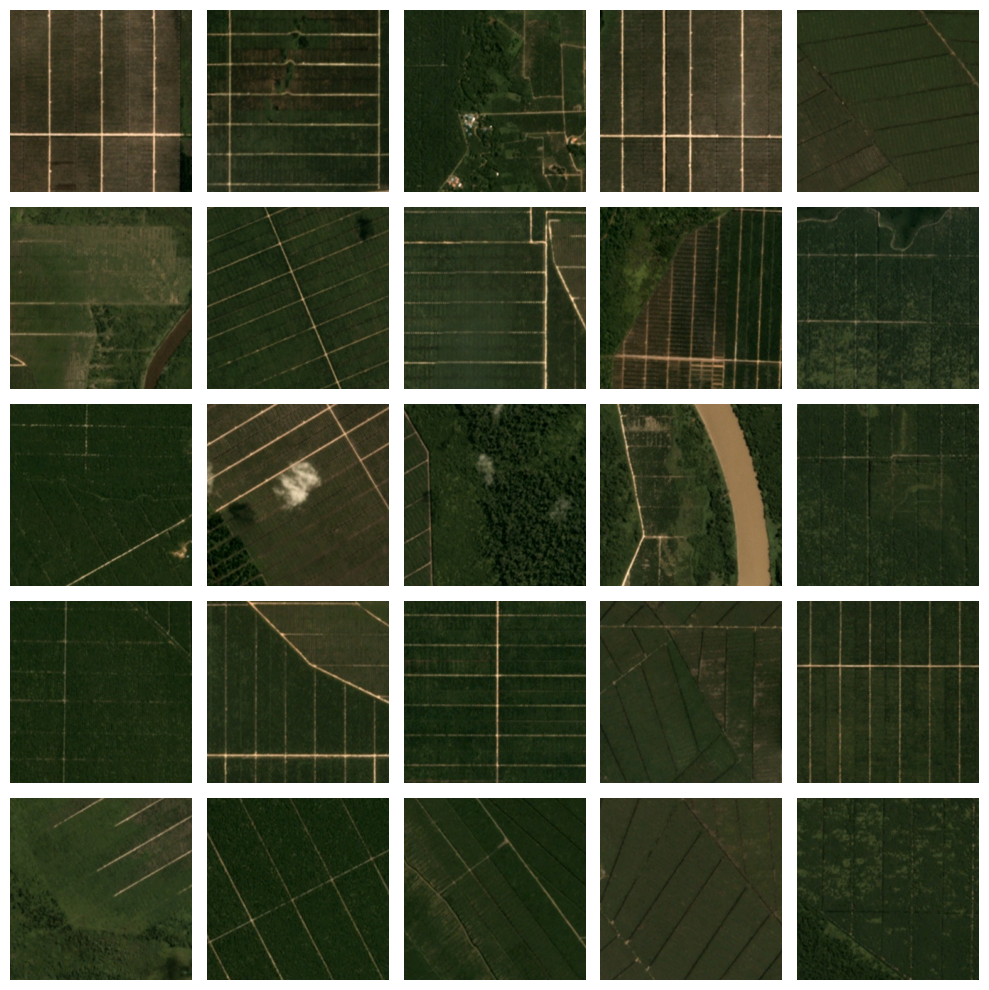

In [23]:
show_images(has_oilpalm)

### No Oil Palm Plantation Images

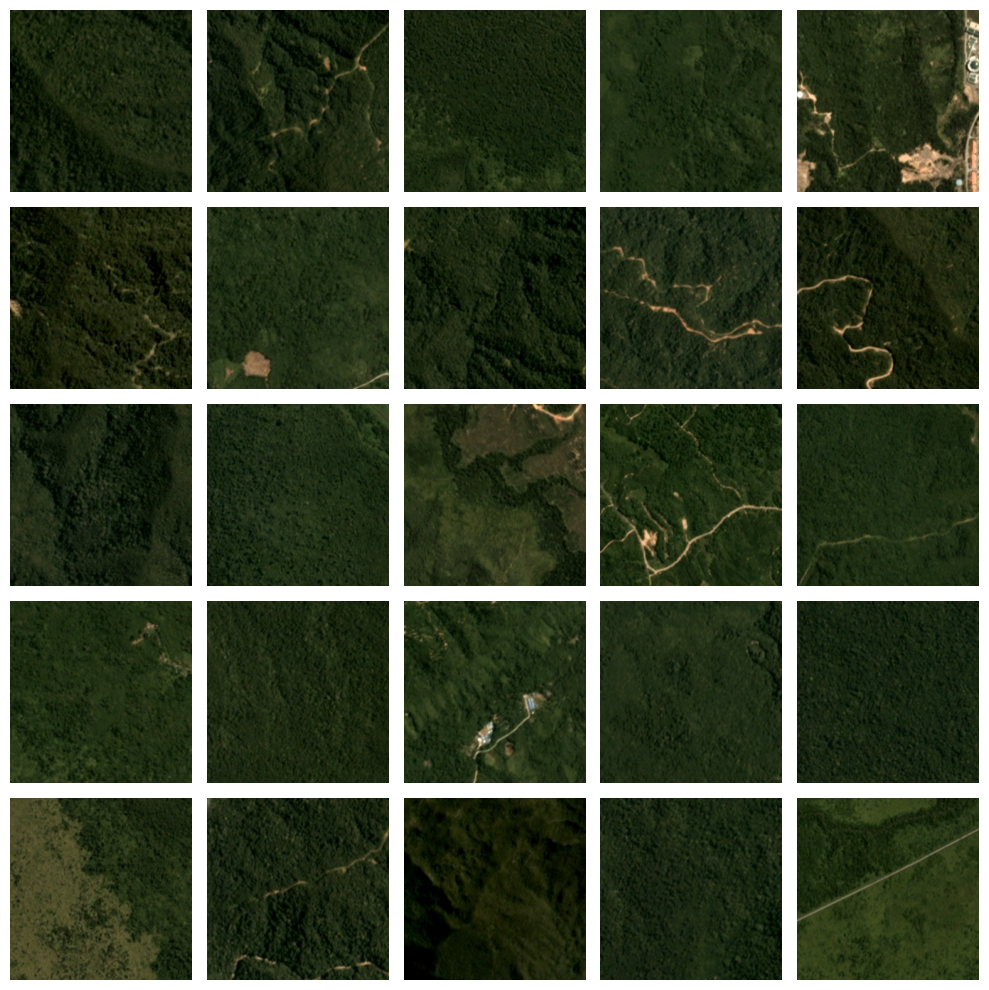

In [24]:
show_images(no_oilpalm)

In the sets of 25 sample images above, distinctive patterns emerge indicating the presence or absence of an oil palm plantation. Images depicting oil palm plantations exhibit evident straight lines and rectangular shapes within the landscape. Conversely, in images without oil palm plantations, the predominant feature is lush greenery, devoid of noticeable straight lines or defined rectangular shapes.

### Images with Low Confidence Score

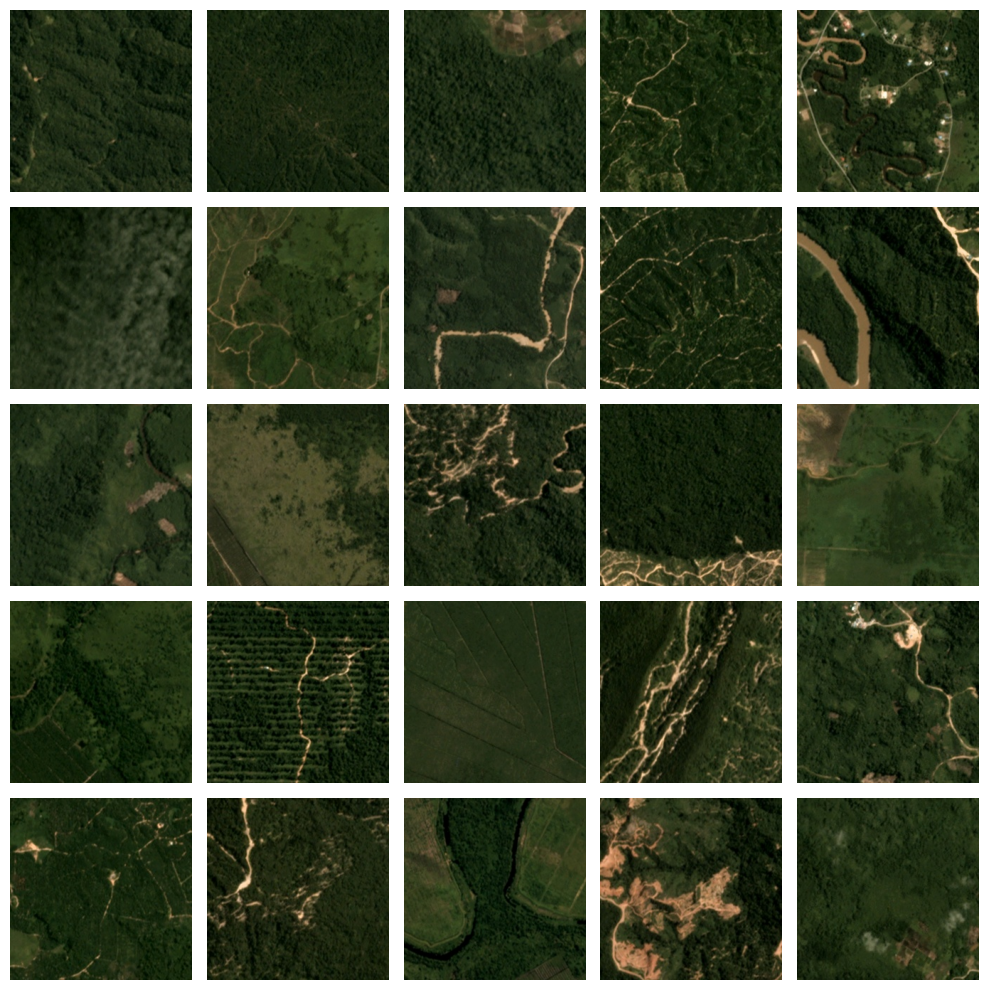

In [25]:
show_images(low_score)

The images displaying lower confidence scores lack discernible patterns. Among these images, some portray dry patches while others appear blurry, lacking distinct visual characteristics or identifiable features.

### Images of Oil Palm Plantation with Scores above 0.8

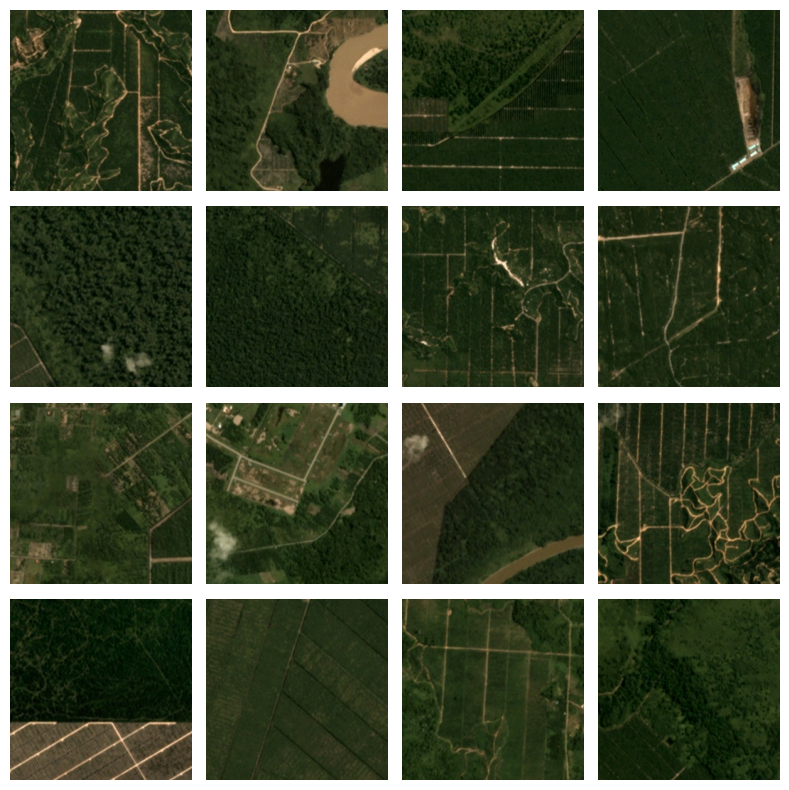

In [26]:
show_images(score_80)

The sample images within the 'score_80' dataframe reveal corners of oil palm plantations or display more intricate features that pose challenges in distinguishing the presence of oil palm plantations compared to images with a confidence score of 1.

# Data Preparation

In [27]:
def image_to_array(file_paths, target_size):
    """This function utilizes the Keras image module to load an image and subsequently returns the image's pixel values as a NumPy array."""
    my_images = []
    for path in file_paths:
        img = image.load_img(path, target_size=target_size)
        img_array = image.img_to_array(img)
        my_images.append(img_array)
    return np.array(my_images)

## Downsampling

Our approach involves downsampling the image data to achieve a balanced representation between images with and without oil palm plantations. To achieve this balance, we'll randomly select images without oil palm plantations to match the number of images containing them.

In [28]:
def final_dataframe_ds(oilpalm_df, oilpalm_df_2, no_oilpalm_df):
    """This function returns the downsampled final training dataframe along with a target dataframe."""
    no_oilpalm_balanced = no_oilpalm_df.sample(oilpalm_df.shape[0] + oilpalm_df_2.shape[0], random_state=0)
    final_train_labels = pd.concat([oilpalm_df, no_oilpalm_balanced, oilpalm_df_2], ignore_index=True)
    final_train_labels = final_train_labels.sample(frac=1, random_state=0).reset_index(drop=True)

    final_target_labels = final_train_labels[['has_oilpalm']]

    return final_train_labels, final_target_labels

In [29]:
def image_data_cleaning_ds(df):
    """This function provides the processed final training data in a NumPy format after performing data cleaning and downsampling."""
    train_ids = df['image_id'].values

    train_paths =[]

    for id in train_ids:
        path = "C:/Users/nene0/Downloads/widsdatathon2019/train_images/" + id + ".jpg"
        train_paths.append(path)
    
    train = image_to_array(train_paths, (224,224,3))
    train = train/255 # Scale the data.

    return train

In [30]:
final_train_labels, final_target = final_dataframe_ds(has_oilpalm, score_80, no_oilpalm)

In [31]:
final_train_labels

image_id  has_oilpalm  score
0    img_02513            0    1.0
1    img_10784            1    1.0
2    img_06422            1    1.0
3    img_02014            1    1.0
4    img_09988            1    1.0
..         ...          ...    ...
759  img_03711            0    1.0
760  img_06032            1    1.0
761  img_01584            0    1.0
762  img_04166            0    1.0
763  img_06744            0    1.0

[764 rows x 3 columns]

In [32]:
final_target

has_oilpalm
0              0
1              1
2              1
3              1
4              1
..           ...
759            0
760            1
761            0
762            0
763            0

[764 rows x 1 columns]

In [33]:
train = image_data_cleaning_ds(final_train_labels)
train

array([[[[0.01960784, 0.09019608, 0.03529412],
         [0.02745098, 0.09803922, 0.03529412],
         [0.01568628, 0.09019608, 0.01176471],
         ...,
         [0.01568628, 0.06666667, 0.        ],
         [0.01568628, 0.05882353, 0.        ],
         [0.02745098, 0.07450981, 0.        ]],

        [[0.03137255, 0.10196079, 0.03921569],
         [0.01568628, 0.09019608, 0.01568628],
         [0.00392157, 0.07843138, 0.        ],
         ...,
         [0.01568628, 0.06666667, 0.        ],
         [0.01568628, 0.05882353, 0.        ],
         [0.02352941, 0.07058824, 0.        ]],

        [[0.02352941, 0.09019608, 0.01960784],
         [0.01176471, 0.07843138, 0.00392157],
         [0.01568628, 0.08627451, 0.        ],
         ...,
         [0.01960784, 0.07058824, 0.00392157],
         [0.01176471, 0.0627451 , 0.        ],
         [0.01176471, 0.0627451 , 0.        ]],

        ...,

        [[0.03137255, 0.08627451, 0.01960784],
         [0.02352941, 0.08235294, 0.00784314]

In [34]:
train.shape

(764, 224, 224, 3)

In [35]:
x_ds = train
y_ds = final_target

In [36]:
# save the downsampled train and target data.
pickle.dump(x_ds, open("train_data_ds.pickle", "wb"))
pickle.dump(y_ds, open("target_data_ds.pickle", "wb"))

## Oversampling

Oversampling in image recognition involves augmenting the minority class images by applying transformations, such as rotation, to create variations. Rotating the image alters its orientation, allowing the algorithm to perceive it as a distinct image from the original one. This augmentation technique aids in providing the model with more diverse examples of the minority class, enhancing its ability to learn and generalize effectively.

Below are the functions designed for this purpose:

- A function to rotate and save the modified images.
- A function to return the oversampled final dataframes, ensuring a balanced representation of classes.
- A function to preprocess and clean the data in preparation for model training.

In [37]:
def save_rotated_oilpalm_images(df):
    """This function saves the rotated oil palm images using the PIL library's Image"""
    df_ids = df['image_id'].values
    df_paths = []

    for id in df_ids:
        path = "C:/Users/nene0/Downloads/widsdatathon2019/train_images/" + id + ".jpg"
        df_paths.append(path)
    
    for path in df_paths:
        rotate_image = Image.open(path).rotate(90)
        new_file_path = path.replace('.jpg', '_rotated.jpg')
        rotate_image.save(new_file_path)

In [38]:
def final_dataframe_os(oilpalm_df, no_oilpalm_df):
    no_oilpalm_500 = no_oilpalm_df.sample(500, random_state=0) # randomly select 500 images

    rotated_oilpalm = oilpalm_df.copy()
    rotated_oilpalm['image_id'] = rotated_oilpalm['image_id'] + "_rotated"

    total_oilpalm = pd.concat([oilpalm_df, rotated_oilpalm], ignore_index=True).sample(500, random_state=0)

    final_train_labels = pd.concat([no_oilpalm_500, total_oilpalm], ignore_index=True) # concat images totaling 1,000
    final_train_labels = final_train_labels.sample(frac=1, random_state=0).reset_index(drop=True)

    final_target_labels = final_train_labels[['has_oilpalm']]

    return final_train_labels, final_target_labels

In [39]:
def image_data_cleaning_os(df):

    train_ids = df['image_id'].values

    train_paths =[]

    for id in train_ids:
        path = "C:/Users/nene0/Downloads/widsdatathon2019/train_images/" + id + ".jpg"
        train_paths.append(path)

    train = image_to_array(train_paths, (224,224,3))
    train = train/255

    return train

In [40]:
save_rotated_oilpalm_images(has_oilpalm)

In [41]:
train_os, target_os = final_dataframe_os(has_oilpalm, no_oilpalm)

In [42]:
x_os = image_data_cleaning_os(train_os)
y_os = target_os

In [43]:
x_os.shape, y_os.shape

((1000, 224, 224, 3), (1000, 1))

In [44]:
pickle.dump(x_os, open("train_data_os.pickle", "wb"))
pickle.dump(y_os, open("target_data_os.pickle", "wb"))

# Test Data (500 Images)

In [45]:
test_label = pd.read_csv(r"C:\Users\nene0\OneDrive\바탕 화면\Python Learning\DataScienceMod2_LFZ\OilPalm_Kaggle\test_label.csv")
test_label

image_id  has_oilpalm   score
0    img_00000            0  0.7895
1    img_00001            0  1.0000
2    img_00002            0  1.0000
3    img_00007            0  1.0000
4    img_00008            0  1.0000
..         ...          ...     ...
495  img_00735            0  1.0000
496  img_00736            1  1.0000
497  img_00737            0  0.7787
498  img_00738            0  1.0000
499  img_00739            0  1.0000

[500 rows x 3 columns]

In [46]:
final_test = image_data_cleaning_ds(test_label)

In [47]:
final_test_target = test_label[['has_oilpalm']]
final_test_target

has_oilpalm
0              0
1              0
2              0
3              0
4              0
..           ...
495            0
496            1
497            0
498            0
499            0

[500 rows x 1 columns]

In [52]:
final_test_target[['has_oilpalm']].value_counts()

has_oilpalm
0              469
1               31
Name: count, dtype: int64

In [49]:
pickle.dump(final_test, open("final_test.pickle", "wb"))
pickle.dump(final_test_target, open("final_test_target.pickle", "wb"))

# Model Train

To expedite neural network training, I've opted to utilize Google Colab, leveraging its accelerated computing capabilities. All progress made in this notebook will be serialized using pickle and stored in my Google Drive for easy access and reproducibility.

The methodology for my model training involves employing transfer learning, a technique pivotal in machine learning. Transfer learning allows for the adaptation of a pretrained model to new, related tasks. With deep learning models demanding substantial datasets and computational resources, training them on standard home computers often proves impractical. Transfer learning mitigates this challenge by leveraging pretrained models' learned representations, significantly reducing the resources needed for training.

In my upcoming work, I aim to conduct separate model training sessions using both undersampled and oversampled datasets. This approach seeks to determine which method yields superior performance. By exploring both undersampling and oversampling techniques, I intend to ascertain the most effective approach for my specific task.